In [2]:
import numpy as np
from matplotlib import pyplot as plt
from pyrap.quanta import quantity
%matplotlib inline

# Faceting

The basic wide field ME is defined as follows:
\begin{equation}
    V(u,v,w)\approx\left<\int{I(l,m,n)e^{2{\pi}i/\lambda[u(l-l_0)+v(m-m_0)+w(n-n_0)]}\frac{dldm}{n}}\right> \text{ where } n:=\sqrt{1-l^2-m^2}
\end{equation}
Any point on the sphere may be shifted (along the sphere) using this relationship (directly stemming from the definition of the fourier transform of a delta function):
\begin{equation}
\begin{split}
    V(u,v,w)&\approx\left<\int{I(l+\Delta{l},m+\Delta{m},n+\Delta{n})e^{2{\pi}i/\lambda[u(l-l_0-l_i+l_0)+v(m-m_0-m_i+m_0)+w(n-n_0-n_i+n_0)]}\frac{dldm}{n}}\right>\\
    &\approx\left<\int{I(l,m,n)e^{2{\pi}i/\lambda[u(l-l_0-\Delta{l})+v(m-m_0-\Delta{m})+w(n-n_0-\Delta{n})]}\frac{dldm}{n}}\right>\\
    &\approx\left<\int{I(l,m,n)e^{2{\pi}i/\lambda[u(l-l_0)+v(m-m_0)+w(n-n_0)]}\frac{dldm}{n}}\right>e^{-2{\pi}i[u\Delta{l},v\Delta{m},w\Delta{n}]}\\
\end{split}
\end{equation}
The basic idea behind facet imaging is to split the celestial sphere up into many small narrow field images. This is achieved by requiring that each visibility is measured with respect to a new phase centre $(l_i,m_i,n_i)$. When we let $(\Delta{l},\Delta{m},\Delta{n}) = (l_i-l_0,m_i-m_0,n_i-n_0)$, the expression above may be used to relate each visibility to the new phase centre (Perley and Cornwell [1992]). It is also easy to see why any phase error introduced by the w term relates to a shift in the position of sources far from the facet phase centre over time. Averaging these visibilities over extended periods of time causes the familiar smearing noticed in widefield images.

Additionally Rick uses a simple coordinate rotation in u and v to tilt the facets to be tangent to the celestial sphere at the new phase centres, in order to ensure that the phase error remains comparable between facets. This approach ensures that the usable field of view remains constant between facets, even if some of the facets are very far away from the original reference centre. 

However, this coordinate transformation alters the sampling function and by implication the PSF associated to each facet. This means that the facets can't be jointly deconvolved, since they are no no longer co-planar. An alternative approach is to project facets onto the same grid before deconvolution (see appendix of Sault et al. [1995]). Alternatively we can take the troubling n-1 term into account through approximations and w-projection-like convolutions in the measurement domain. These are discussed below.

# W-Projection

## Overview

Cornwell [2008]. The $w(n-n_i)$ term may be multiplied back into the exponential through convolution in the fourier (measurement) domain. The convolution theorem tells us that:
\begin{equation}
    \begin{split}
        V(u,v,w) * F(u,v,w) &\leftrightarrows^\mathcal{F} I(l,m,n)f(l,m,n)\\
        V(u,v,w)F(u,v,w) &\leftrightarrows^\mathcal{F} I(l,m,n)*f(l,m,n)\\
    \end{split}
\end{equation}
We begin by seperating out $w(n-n_i)$ (where $\vec{s_i} = <0,0,1>$ at the initial phase centre $i=0$) from the ME:
\begin{equation}
    \begin{split}
    V(u,v,w)&\approx\left<\int{I(l,m,n)e^{2{\pi}i/\lambda[u(l-l_i)+v(m-m_i)]}e^{2{\pi}i/\lambda[w(n-n_i)]}\frac{dldm}{n}}\right>\\
    &\approx\left<\int{I(l,m,n)e^{2{\pi}i/\lambda[u(l-l_i)+v(m-m_i)]}W(l,m,w)\frac{dldm}{n}}\right>\\
    &\approx\left<V(u,v,w=0)*w(u,v,w)\right>\\
    \end{split}
\end{equation}

The predominant problem here is that a $w$ kernel has to be generated for many discrete "w-planes". For architectures with large caches (CPUs) this is not a big hurdle. However, for GPU architectures the shared memory available per multiprocessor to store such kernels is rather small (64 KB cache on compute 2.x and 3.x cards). Furthermore here $W(l,m,w)$ is not a seperable function, meaning $W(l,m,w){\neq}W(l,w)W(m,w)$ for some w-dependent 1D function, unlike the anti-aliasing filter normally used in convolutional gridding. This means the filter cannot be stored as a 1D filtering kernel, but instead has to be stored as a 2D kernel. Considering that such a filter must be oversampled and usually has a full support region orders of magnitude bigger (depending on array configuration and image size) than a normal anti-aliasing kernel, it effectively precludes storing these stacks of w-dependent filters in GPU shared memory. Depending on the size of these filter layers it can be taxing to store these in global device memory.

## Support

For long baselines the W term has significantly short oscilations near the edge of the field (see below). This requires that the W term be sampled at high resolutions, unlike the slow-varying tapering function. W has to be sampled at a high resolution to satisfy nyquest sampling and cut down on aliasing in $n$.

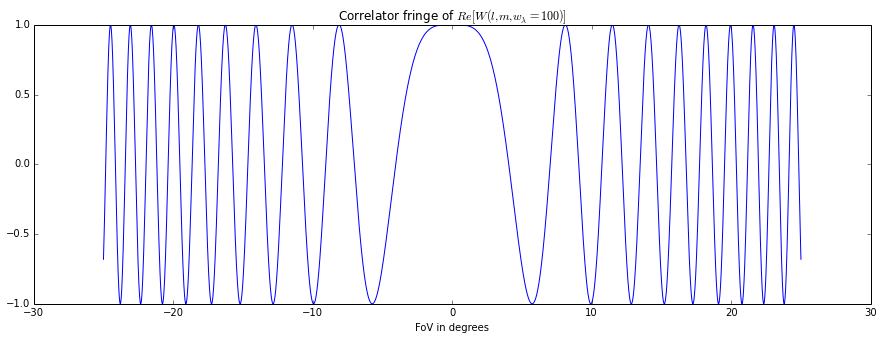

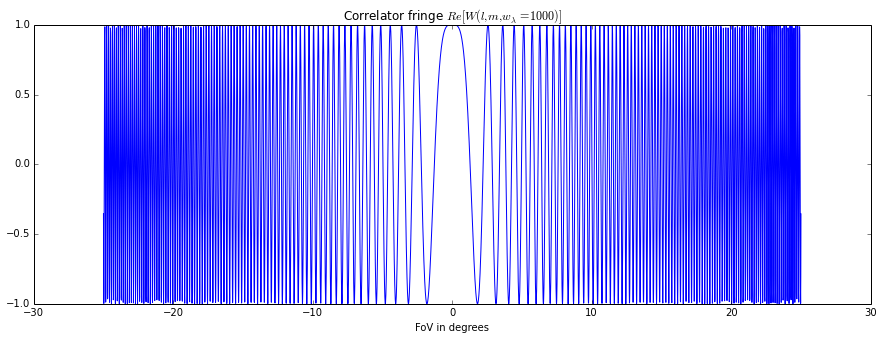

In [3]:
theta_max = np.deg2rad(25)
samp = 4096
theta = np.linspace(-theta_max,theta_max,samp)
m = np.sin(theta)#*cos(phi_0 = 0) = 1
n_min_1 = np.sqrt(1 - m**2) - 1
plt.figure(figsize=(15, 5),dpi=300)
plt.title("Correlator fringe of $Re[W(l,m,w_\lambda=100)]$")
plt.xlabel("FoV in degrees")
plt.plot(np.rad2deg(theta),np.cos(2*np.pi*n_min_1*100))
plt.figure(figsize=(15, 5),dpi=300)
plt.title("Correlator fringe $Re[W(l,m,w_\lambda=1000)]$")
plt.xlabel("FoV in degrees")
plt.plot(np.rad2deg(theta),np.cos(2*np.pi*n_min_1*1000))
plt.show()

Cyril (Applying full polarization A-projection to very wide field of view instruments: an imager for LOFAR) points out that this support size is roughly given as:
\begin{equation}
W_{sup}=\frac{4{\pi}w_{\lambda}D^2_{im}}{\sqrt{2-D^2_{im}}}
\end{equation}


## Worked w-projection kernel generation code

Each W kernel should be multiplied with the fourier transform of the Anti-Aliasing filter and then fourier transformed. By the convolution theorem we should obtain a filter that is given by $w(u,v,w) * c(u,v)$. It is not necessary to generate any kernels for negative w. Simply swap the baseline for the negative baseline and grid the conjugate visibility. Thompson (p24, Synthesis Imaging II) points out that the w component of any baseline is maximum when the horizon (low elevation) and when the source direction has a comparable azimuth angle to the baseline. 
\begin{equation}
w_{max} = \frac{||b_{longest}||}{\lambda_{min}}
\end{equation}

Half support in fourier space 15, with oversampling factor 10
Half support in image space 0.9375, with oversampling factor 16.0
Recommended half support region for the kernel in image space 419
Recommended half support region for the kernel in fourier space 670


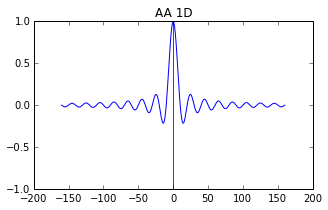

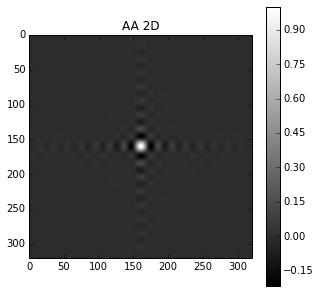

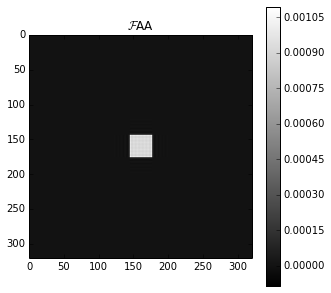

Extent in declination, right assention (0.044680,0.044680) from phase centre


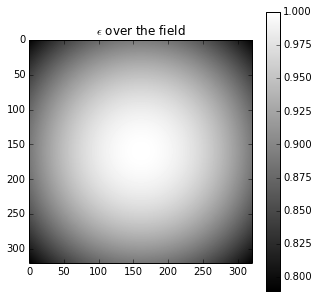

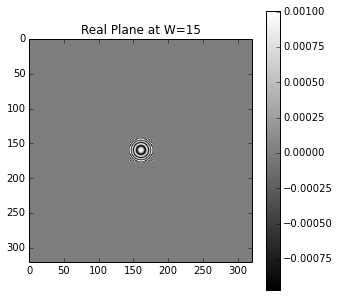

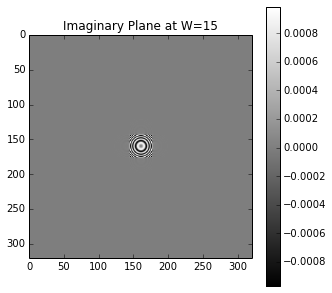

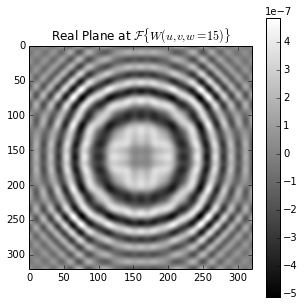

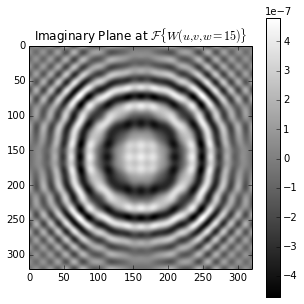

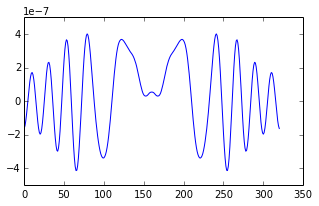

In [4]:
'''
image parameters
'''
npix_l = 1024
npix_m = 1024
celll = quantity(18,"arcsec").get_value("rad")
cellm = quantity(18,"arcsec").get_value("rad")
dec_max = npix_l * celll
ra_max = npix_m * cellm
dec_0 = quantity(-0*60*60,"arcsec").get_value("rad")
ra_0 = quantity(0,"arcsec").get_value("rad")
'''
kernel perameters
'''
sup = 15
full_support = (sup) * 2 + 1
padded_full_support = full_support + 2 #padding by oversample number of samples at both ends
oversample = 10
convolution_size = padded_full_support + ((padded_full_support - 1) * (oversample - 1)) #filter array dimension size
convolution_centre = convolution_size // 2
oversample_image_space = (oversample / (float(convolution_centre)))**-1
sup_image_space = sup / float(oversample_image_space)#((full_support + (full_support - 1) * (oversample - 1)) // 2) / float(oversample_image_space)
print "Half support in fourier space %s, with oversampling factor %s" % (sup,oversample)
print "Half support in image space %s, with oversampling factor %s" % (sup_image_space,oversample_image_space)
wplanes = 32
'''
Measurement parameters
'''
w_lambda_max = 5868.5021379585378

'''
Compute recommended support
'''
image_diam = np.sqrt(ra_max**2 + dec_max**2)
#Recommended support as per Tasse (Applying full polarization A-projection to very wide field of view instruments: an imager for LOFAR)
recommended_half_support_image = int(np.ceil(((4 * np.pi * w_lambda_max * image_diam**2) / np.sqrt(2 - image_diam**2)) * 0.5))
recommended_half_support = recommended_half_support_image * (oversample_image_space/float(oversample))
print "Recommended half support region for the kernel in image space %d" % recommended_half_support_image
print "Recommended half support region for the kernel in fourier space %d" % recommended_half_support

x = np.arange(0, convolution_centre+1)
x = np.hstack((-x[::-1],x[1:]))
#compute the Anti aliasing kernel
'''
Sinc function with discontinuity removed
'''
AA_1D = np.sinc(x/float(oversample))

plt.figure(figsize=(5, 3),dpi=300)
plt.title("AA 1D")
plt.plot(x,AA_1D)
plt.plot((x[x.shape[0]//2],x[x.shape[0]//2]),(1,-1))
plt.show()

AA_2D = np.outer(AA_1D,AA_1D)

plt.figure(figsize=(5, 5),dpi=300)
plt.title("AA 2D")
plt.imshow(AA_2D,cmap=plt.cm.gray)
plt.colorbar()
plt.show()

FAA = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(AA_2D))) / ((padded_full_support*oversample)**2)
plt.figure(figsize=(5, 5),dpi=300)
plt.title("$\mathcal{F}$AA")
plt.imshow(np.real(FAA),cmap=plt.cm.gray)
plt.colorbar()
plt.show()

'''
generate the filter over theta and phi where
l = cos(dec)*sin(ra-ra0)
m = sin(dec)*cos(dec0)-cos(dec)*sin(dec0)*cos(ra-ra0)
n = sqrt(1-l**2-m**2)
'''

dec = x / float(oversample_image_space) / float(sup_image_space) * (dec_max * 0.5) 
ra = x / float(oversample_image_space) / float(sup_image_space) * (ra_max * 0.5) 
print "Extent in declination, right assention (%f,%f) from phase centre" % (dec_max * 0.5,ra_max * 0.5)

decg,rag = np.meshgrid(dec,ra,indexing='ij')

l = np.cos(decg+dec_0)*np.sin(rag)
m = np.sin(decg+dec_0)*np.cos(dec_0)-np.cos(decg+dec_0)*np.sin(dec_0)*np.cos(rag)
n = np.sqrt(1-l**2-m**2)

plt.figure(figsize=(5, 5),dpi=300)
plt.title("$\epsilon$ over the field")
plt.imshow(n,cmap=plt.cm.gray)
plt.colorbar()
plt.show()

#now get the cos and sine fringes
W_kernels = np.empty([wplanes,
                      convolution_size,
                      convolution_size],dtype=np.complex64)
W_bar_kernels = np.empty([wplanes,
                      convolution_size,
                      convolution_size],dtype=np.complex64)
plane_step = w_lambda_max / float(wplanes-1)
for w in range(0,wplanes):
    W_kernels[w,:,:] = FAA*np.exp(-2*np.pi*1.0j*(n-1)* ((w)*plane_step)) 
    W_bar_kernels[w,:,:] = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(W_kernels[w,:,:]))) / ((padded_full_support*oversample)**2)
w_to_plot = 15
plt.figure(figsize=(5, 5),dpi=300)
plt.title("Real Plane at W=%d"%w_to_plot)
plt.imshow(np.real(W_kernels[w_to_plot,:,:]),cmap=plt.cm.gray)
plt.colorbar()
plt.figure(figsize=(5, 5),dpi=300)
plt.title("Imaginary Plane at W=%d"%w_to_plot)
plt.imshow(np.imag(W_kernels[w_to_plot,:,:]),cmap=plt.cm.gray)
plt.colorbar()
plt.figure(figsize=(5, 5),dpi=300)
plt.title("Real Plane at $\mathcal{F}\{W(u,v,w=%d)\}$"%w_to_plot)
plt.imshow(np.real(W_bar_kernels[w_to_plot,:,:]),cmap=plt.cm.gray)
plt.colorbar()
plt.figure(figsize=(5, 5),dpi=300)
plt.title("Imaginary Plane at $\mathcal{F}\{W(u,v,w=%d)\}$"%w_to_plot)
plt.imshow(np.imag(W_bar_kernels[w_to_plot,:,:]),cmap=plt.cm.gray)
plt.colorbar()
plt.figure(figsize=(5, 3),dpi=300)
plt.plot(np.real(W_bar_kernels[w_to_plot,W_bar_kernels.shape[1]/2,:]))
plt.show()

#Seperable kernel generation

## Coplanar faceting with Taylor expansion up to the first term

Geisen & Kogan [2009] uses a small taylor expansion (to the first term) to approximate the multi-variable function about the new phase centre $(l_i,m_i,n_i)$:
\begin{equation}
    \begin{split}
        f(l,m)&=w(n-n_i)=w\left(\sqrt{1-l^2-m^2}-\sqrt{1-l_i^2-m_i^2}\right)\\
        f(l,m)&{\approx}w\left[f(l_i,m_i) + f_l(l_i,m_i)(l-l_i) + f_m(l_i,m_i)(m-m_i)\right]\\
        f(l,m)&{\approx}-\frac{l_i(l-l_i)+m_i(l-l_i)}{n_i}
    \end{split}
\end{equation}
Substituting back and taking out common the common $l-l_i$ and $m-m_i$ factors this relates to a simple transformation of the u,v coordinates. This approach of course relies on a very simple approximation of $n-n_i$. The plot below shows how the taylor approximation near the new phase centre breaks down over extended fields of view. Unfortunately further expanding the approximation does not yield a form where common factors can be taken out readily. To bring these factors back into the equation will envolve a technique resembling w-projection.

It is more accurate (except very far away from to original phase centre - far outside the primary and secondary beams of the telescope) to approximate the residual W-kernel as:
\begin{equation}
W(l,m,w) = e^{2{\pi}wi\sqrt{1-(l-l_i)^2-(m-m_i)^2}} - 1
\end{equation}

This is indicated below. Unfortunately this is not a seperable convolution function.

## Small angle approximation

If we use small angle approximation ($\sqrt{1+x}\approx1+\frac{x}{2}$) to W(l,m,n) with respect to a facet centre we get the following linearly seperable relation:
\begin{equation}
   W(l,m,w) = e^{2{\pi}iw[(l_i^2-l^2)/2]}e^{2{\pi}iw[(m_i^2-m^2)/2]}
\end{equation}
Seperating out $l_i$ and $m_i$ to be applied by the normal faceting phase shift we get the same small angle version of the equation stated in Cornwell [2008].
Assuming the normal anti-aliasing gridding function is seperable as well this becomes
\begin{equation}
   \begin{split}
   c(l,m)W(l,m,w) &= c(u)c(v)e^{-2{\pi}iw[(l^2)/2]}e^{-2{\pi}iw[(m^2)/2]}\\
                             &= k(u)k(v)\\
                             &= k(u,v)\\
                             &\rightleftharpoons^\mathcal{F} K(u,v)\\
                             &=K(u)K(v)\\
   \end{split}
\end{equation}
The small angle approximation is much more accurate that the simple planar approximation given by the taylor expansion abait not nearly as accurate as the non-seperable residual filter of the taylor expansion discussed earlier (shown in red). A 2D polynomial fit will give the best results, although this is not seperable and non-axisemetric (personal communications Cyril Tasse).

Unfortunately even though this small angle approximation at first glance looks promising it does not appear to have a very simple analytic fourier transform. This means that we still have to store $N_{planes}\times[W_{sup} + (W_{sup} - 1)\times(N_{oversampled} - 1)]$ complex filter taps. This improves the memory requirements significantly. We choose this approach as an alternative to non-coplanar faceting. No coordinate transformation on u and v is necessary, we simply convolve the terms back in.

## Error reduction properties of the different approaches

In [5]:
def compute_lmn(phase_centres,image_coordinate):
    delta_ra = - phase_centres[0] + image_coordinate[0]
    dec0 = phase_centres[1]
    dec = image_coordinate[1]
    return (np.cos(dec)*np.sin(delta_ra),
            np.sin(dec)*np.cos(dec0)-np.cos(dec)*np.sin(dec0)*np.cos(delta_ra),
            np.sin(dec)*np.sin(dec0)+np.cos(dec)*np.cos(dec0)*np.cos(delta_ra))

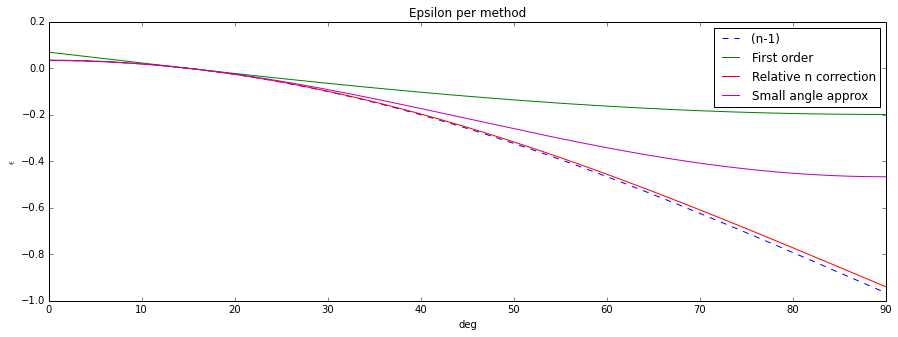

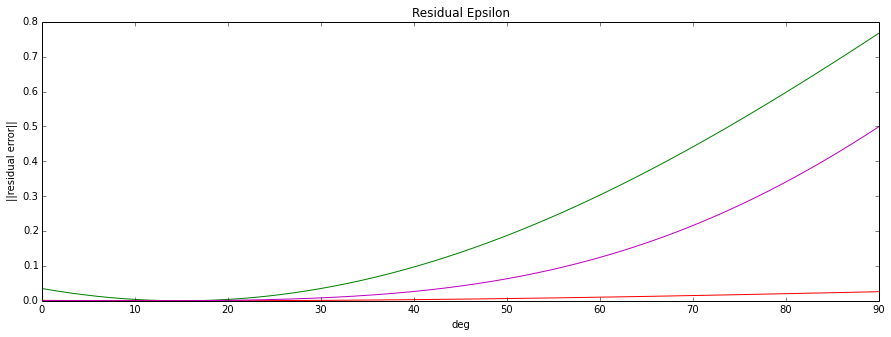

In [6]:
theta_0 = np.deg2rad(0)
max_theta = np.deg2rad(90)
theta_i = np.deg2rad(15) #new phase centre
samp = 2048

theta = np.linspace(theta_0,max_theta + theta_0,samp)
#use relative theta,phi angles in spherical coords (can alternatively use the relations for ra,dec here)
m_0 = np.sin(theta_0)#*cos(phi_0 = 0) = 1
m_i = np.sin(theta_i)#*cos(phi_i = 0) = 1
m = np.sin(theta)#*cos(phi = 0) = 1
n_i = np.sqrt(1-m_i**2)
n = np.sqrt(1-m**2)
epsilon = n - n_i
approx_epsilon_1term = -m_i * (m - m_i) / np.sqrt(1 - m_i**2)
delta_l = np.sin(theta - theta_i)
approx_epsilon_1term_plus_residual_approx = approx_epsilon_1term + (np.sqrt(1 - (delta_l)**2) - 1)
dn_small_angle = (-m**2 + m_i**2)*0.5
plt.figure(figsize=(15, 5),dpi=300)
plt.title("Epsilon per method")
plt.xlabel("deg")
plt.ylabel("$\epsilon$")
plt.plot(np.rad2deg(theta),epsilon,"--b",label="(n-1)")
plt.plot(np.rad2deg(theta),approx_epsilon_1term,"g",label="First order")
plt.plot(np.rad2deg(theta),approx_epsilon_1term_plus_residual_approx,"r",label="Relative n correction")
plt.plot(np.rad2deg(theta),dn_small_angle,"m",label="Small angle approx")
plt.legend(bbox_to_anchor=(1, 1))
plt.figure(figsize=(15, 5),dpi=300)
plt.title("Residual Epsilon")
plt.xlabel("deg")
plt.ylabel("||residual error||")
plt.plot(np.rad2deg(theta),np.abs(epsilon - approx_epsilon_1term),"g")
plt.plot(np.rad2deg(theta),np.abs(epsilon - approx_epsilon_1term_plus_residual_approx),"r")
plt.plot(np.rad2deg(theta),np.abs(epsilon - dn_small_angle),"m")
plt.show()

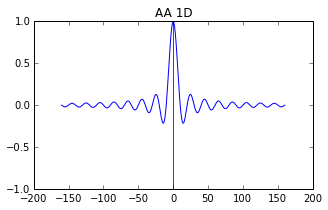

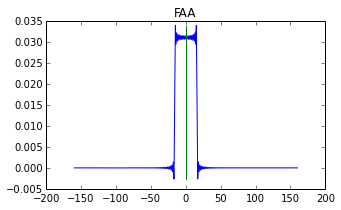

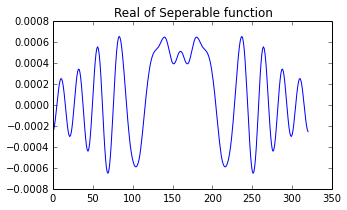

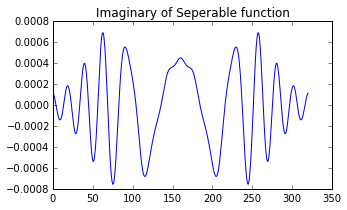

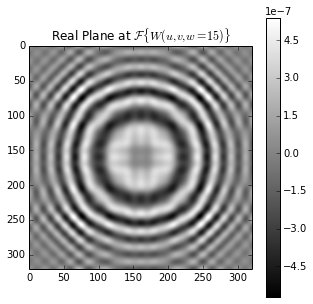

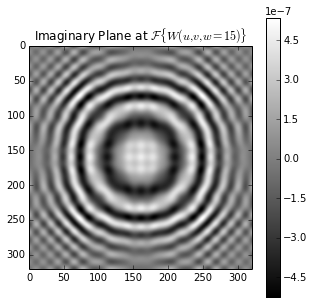

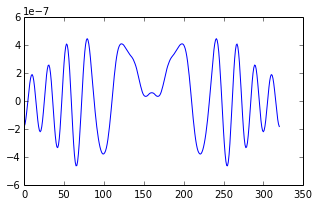

In [7]:
#Run w-projection example before running this
FAA = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(AA_1D))) / (AA_1D.shape[0])
plt.figure(figsize=(5, 3),dpi=300)
plt.title("AA 1D")
plt.plot(x,AA_1D)
plt.plot((x[x.shape[0]//2],x[x.shape[0]//2]),(1,-1))
plt.show()
plt.figure(figsize=(5, 3),dpi=300)
plt.title("FAA")
plt.plot(x,np.real(FAA))
plt.plot((x[x.shape[0]//2],x[x.shape[0]//2]),(np.max(np.real(FAA)),np.min(np.real(FAA))))
plt.show()

#approximate l and m cosines... should be okay for small angles
lm = x / float(oversample_image_space) / float(sup_image_space) * (max(npix_l * celll * 0.5,npix_m * cellm * 0.5))
W_kernels = np.empty([wplanes,
                      convolution_size],dtype=np.complex64)
W_bar_kernels = np.empty([wplanes,
                          convolution_size],dtype=np.complex64)
plane_step = w_lambda_max / float(wplanes-1)
for w in range(0,wplanes):
    W_kernels[w,:] = FAA*np.exp(2*np.pi*1.0j*(lm**2)*0.5*((w)*plane_step)) 
    W_bar_kernels[w,:] = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(W_kernels[w,:]))) / (W_kernels.shape[1])
w_to_plot = 15
k = np.outer(W_bar_kernels[w_to_plot,:],W_bar_kernels[w_to_plot,:])
plt.figure(figsize=(5, 3),dpi=300)
plt.title("Real of Seperable function")
plt.plot(np.real(W_bar_kernels[w_to_plot,:]))
plt.figure(figsize=(5, 3),dpi=300)
plt.title("Imaginary of Seperable function")
plt.plot(np.imag(W_bar_kernels[w_to_plot,:]))
plt.figure(figsize=(5, 5),dpi=300)
plt.title("Real Plane at $\mathcal{F}\{W(u,v,w=%d)\}$"%w_to_plot)
plt.imshow(np.real(k),cmap=plt.cm.gray)
plt.colorbar()
plt.figure(figsize=(5, 5),dpi=300)
plt.title("Imaginary Plane at $\mathcal{F}\{W(u,v,w=%d)\}$"%w_to_plot)
plt.imshow(np.imag(k),cmap=plt.cm.gray)
plt.colorbar()
plt.show()
plt.figure(figsize=(5, 3),dpi=300)
plt.plot(np.real(k[k.shape[1]/2,:]))
plt.show()